In [1]:
import csv
import datetime
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import xgboost as xgb
import math

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tensorflow import keras
from tensorflow.keras import models, optimizers
from tensorflow.keras.layers import Dense, BatchNormalization
from yellowbrick.regressor import ResidualsPlot

import seaborn as sns;
sns.set_style('whitegrid')

### Read Data

We take the splited train and test dataset generated from the **preprocess.ipynb** as input.

In [2]:
def read_from_csv(path):
    df = pd.read_csv(path, index_col=0)
    return df

In [3]:
train_path = './data/train.csv'
test_path = './data/test.csv'

X_train, X_test = read_from_csv(train_path, ), read_from_csv(test_path)
len(X_train), len(X_test)

(956866, 239217)

In [4]:
y_train, y_test = pd.DataFrame(X_train['duration']), pd.DataFrame(X_test['duration'])

X_train.drop(columns=['duration'], inplace=True)
X_test.drop(columns=['duration'], inplace=True)

Here, we apply the [root-mean-square error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) (RMSE) as the metric for regression.

In [5]:
def get_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

# Model 

Our task is to build a regression model to predict the duration of a yellow taxi trip. We apply linear regression model as our baseline model. To capture the non-linear relationship between features and target, we further use XgBoost, Gradient Boost, Random Forest and Neural Networks for prediction. We implement parameter searching and tuning for those models to get the best results. We take root mean square error as evaluation metric. Finally, we plan to compare and analyze among different models.

## Linear Regression

For linear regression model, we choose four different variations. The simplest version of linear model shows as follow:
$$ \hat y = w_{1}x_{1} + w_{1}x_{1} + ... w_{n}x_{n} + b $$

The cost function is:
$$ \sum_{i=1}^{N} (y_{i} - w_{i}^{T} x_{i}) $$

For Ridge regression, the cost function consists of loss and regularization part. Regularization part equals to square of the magnitude of the coefficients:
$$ \sum_{i=1}^{N} (y_{i} - w_{i}^{T} x_{i}) + \lambda \sum_{j=0}^{F}w_{j}^{2}$$

For Lasso regression, regularization part of cost function is sum of absolute value of weights. This L1 regularization can shrink and completely neglect some of the features:
$$ \sum_{i=1}^{N} (y_{i} - w_{i}^{T} x_{i}) + \lambda \sum_{j=0}^{F}|w_{j}|$$

For [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) regression, it combines both L1 and L2 regularization into cost function.

Through the test, we find normalization will make performance worse, so we choose to use the default "normalize=False".

In [6]:
# https://scikit-learn.org/stable/modules/linear_model.html
model_lr = LinearRegression().fit(X_train, y_train)
model_ridge = Ridge().fit(X_train, y_train)
model_lasso = Lasso().fit(X_train, y_train)
model_elasticnet = ElasticNet().fit(X_train, y_train)

In [7]:
# Train
y_pred1 = model_lr.predict(X_train)
y_pred2 = model_ridge.predict(X_train)
y_pred3 = model_lasso.predict(X_train)
y_pred4 = model_elasticnet.predict(X_train)

train_loss1 = get_rmse(y_train, y_pred1)
train_loss2 = get_rmse(y_train, y_pred2)
train_loss3 = get_rmse(y_train, y_pred3)
train_loss4 = get_rmse(y_train, y_pred4)

print("Train Loss for Linear Regression: {}".format(train_loss1))
print("Train Loss for Ridge Regression: {}".format(train_loss2))
print("Train Loss for Lasso Regression: {}".format(train_loss3))
print("Train Loss for Elastic_Net Regression: {}".format(train_loss4))

Train Loss for Linear Regression: 1.765099519036676
Train Loss for Ridge Regression: 1.7651487349692965
Train Loss for Lasso Regression: 2.4909569470445274
Train Loss for Elastic_Net Regression: 2.881458465204252


In [8]:
# Test
y_pred1 = model_lr.predict(X_test)
y_pred2 = model_ridge.predict(X_test)
y_pred3 = model_lasso.predict(X_test)
y_pred4 = model_elasticnet.predict(X_test)

test_loss1 = get_rmse(y_test, y_pred1)
test_loss2 = get_rmse(y_test, y_pred2)
test_loss3 = get_rmse(y_test, y_pred3)
test_loss4 = get_rmse(y_test, y_pred4)

print("Test Loss for Linear Regression: {}".format(test_loss1))
print("Test Loss for Ridge Regression: {}".format(test_loss2))
print("Test Loss for Lasso Regression: {}".format(test_loss3))
print("Test Loss for Elastic_Net Regression: {}".format(test_loss4))

Test Loss for Linear Regression: 1.8167394999483772
Test Loss for Ridge Regression: 1.8169582293069853
Test Loss for Lasso Regression: 2.5389284225296254
Test Loss for Elastic_Net Regression: 2.924817683704197


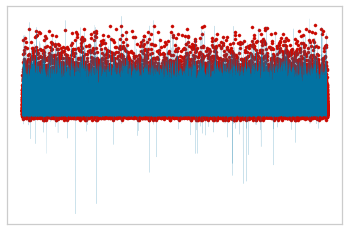

In [9]:
# Plot output, take "model_lr" as example
plt.scatter(np.arange(X_test.shape[0]), y_test, color='r', s=10)
plt.plot(np.arange(X_test.shape[0]), y_pred1, color='b', linewidth=0.1)

plt.xticks(())
plt.yticks(())
plt.show()

## XGBoost

Xgboost uses K additive functions to predict the output. The output is sum of scores predicted by each of the tree. Instead learning weights like in linear regression, XgBoost is learning functions (trees) in each iteration.

The objective funcion consists of train loss and regularization part. The training process starts from constant output. At each time add a new function which minimize the above objective function:

$$ Obj^{t} = \sum_{i=1}^{n} l(y_{i}, \hat {y_{i}}^{t-1}+f_{t}(x_{i})) + \Omega (f_{t}) \quad f_{t} \subseteq F \, (all \, regression \, trees) $$

In [10]:
params = { 
    'booster': 'gbtree',
    'objective':'reg:linear',
    'learning_rate': 0.2,
    'n_estimators': 200,
    'objective': 'reg:linear',  
    'gamma': 0.3,                  # control pruning
    'max_depth':5 ,               
    'lambda': 2,                   # L2 parameter
    'subsample': 0.8,              # random sample 
    'colsample_bytree': 0.7,       # col sample when generate tree
    'min_child_weight': 1,
    'silent': 0,
    'reg_alpha': 0
}

In [11]:
model_xgboost = xgb.XGBRegressor(
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        booster=params['booster'],
        objective=params['objective'],
        n_jobs=-1,
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        random_state=0,
        silent=params['silent'],
        max_depth=params['max_depth'],
        gamma=params['gamma'],
        min_child_weight=params['min_child_weight'],
        reg_alpha=params['reg_alpha']
    )

model_xgboost.fit(X_train, y_train)

[18:09:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.3,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=0,
             subsample=0.8, verbosity=1)

In [12]:
# Train
y_pred = model_xgboost.predict(X_train)
train_loss = get_rmse(y_train, y_pred)
print("Train Loss: {}".format(train_loss))

Train Loss: 1.4249215300207867


In [13]:
# Test
y_pred = model_xgboost.predict(X_test)
test_loss = get_rmse(y_test, y_pred)
print("Test Loss: {}".format(test_loss))

Test Loss: 1.537685194760057


### Grid Search Parameters for Xgboost

Considering time complexity and effect on result, we choose "learning rate", "number of estimators" and "gamma" as tunning parameter. 

In [16]:
# A parameter grid for XGBoost
params = {
        'booster': 'gbtree',
        'objective':'reg:squarederror',
        'max_depth': 5,
        'lambda': 2,                   # L2 parameter
        'subsample': 0.8,              # random sample
        'colsample_bytree': 0.7,       # col sample when generate tree
        'min_child_weight': 1,
        'reg_alpha': 0,
        'verbosity':1
    }

search_params={
        'learning_rate': [0.1, 0.2, 0.3],
        'n_estimators': [100, 200, 300],
        'gamma': [1, 2, 5, 10],
    }

model_xgboost = xgb.XGBRegressor(
        booster=params['booster'],
        objective=params['objective'],
        n_jobs=-1,
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        random_state=0,
        max_depth=params['max_depth'],
        min_child_weight=params['min_child_weight'],
        reg_alpha=params['reg_alpha'],
        verbosity=params['verbosity']
    )

cv_folders = 5
gs = GridSearchCV(model_xgboost, search_params, scoring="neg_mean_absolute_error", cv=cv_folders, verbose=2)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] gamma=0.5, learning_rate=0.1, n_estimators=100 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... gamma=0.5, learning_rate=0.1, n_estimators=100, total=  27.2s
[CV] gamma=0.5, learning_rate=0.1, n_estimators=100 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.2s remaining:    0.0s


[CV] ... gamma=0.5, learning_rate=0.1, n_estimators=100, total=  28.3s
[CV] gamma=0.5, learning_rate=0.1, n_estimators=100 ..................
[CV] ... gamma=0.5, learning_rate=0.1, n_estimators=100, total=  27.2s
[CV] gamma=0.5, learning_rate=0.1, n_estimators=100 ..................
[CV] ... gamma=0.5, learning_rate=0.1, n_estimators=100, total=  26.2s
[CV] gamma=0.5, learning_rate=0.1, n_estimators=100 ..................
[CV] ... gamma=0.5, learning_rate=0.1, n_estimators=100, total=  26.6s
[CV] gamma=0.5, learning_rate=0.1, n_estimators=200 ..................
[CV] ... gamma=0.5, learning_rate=0.1, n_estimators=200, total=  48.8s
[CV] gamma=0.5, learning_rate=0.1, n_estimators=200 ..................
[CV] ... gamma=0.5, learning_rate=0.1, n_estimators=200, total=  55.5s
[CV] gamma=0.5, learning_rate=0.1, n_estimators=200 ..................
[CV] ... gamma=0.5, learning_rate=0.1, n_estimators=200, total=  45.6s
[CV] gamma=0.5, learning_rate=0.1, n_estimators=200 ..................
[CV] .

[CV] ..... gamma=1, learning_rate=0.1, n_estimators=300, total= 1.1min
[CV] gamma=1, learning_rate=0.2, n_estimators=100 ....................
[CV] ..... gamma=1, learning_rate=0.2, n_estimators=100, total=  25.6s
[CV] gamma=1, learning_rate=0.2, n_estimators=100 ....................
[CV] ..... gamma=1, learning_rate=0.2, n_estimators=100, total=  22.1s
[CV] gamma=1, learning_rate=0.2, n_estimators=100 ....................
[CV] ..... gamma=1, learning_rate=0.2, n_estimators=100, total=  26.1s
[CV] gamma=1, learning_rate=0.2, n_estimators=100 ....................
[CV] ..... gamma=1, learning_rate=0.2, n_estimators=100, total=  22.8s
[CV] gamma=1, learning_rate=0.2, n_estimators=100 ....................
[CV] ..... gamma=1, learning_rate=0.2, n_estimators=100, total=  23.7s
[CV] gamma=1, learning_rate=0.2, n_estimators=200 ....................
[CV] ..... gamma=1, learning_rate=0.2, n_estimators=200, total=  44.5s
[CV] gamma=1, learning_rate=0.2, n_estimators=200 ....................
[CV] .

[CV] ... gamma=1.5, learning_rate=0.2, n_estimators=300, total= 1.3min
[CV] gamma=1.5, learning_rate=0.2, n_estimators=300 ..................
[CV] ... gamma=1.5, learning_rate=0.2, n_estimators=300, total= 1.3min
[CV] gamma=1.5, learning_rate=0.2, n_estimators=300 ..................
[CV] ... gamma=1.5, learning_rate=0.2, n_estimators=300, total= 1.1min
[CV] gamma=1.5, learning_rate=0.3, n_estimators=100 ..................
[CV] ... gamma=1.5, learning_rate=0.3, n_estimators=100, total=  22.4s
[CV] gamma=1.5, learning_rate=0.3, n_estimators=100 ..................
[CV] ... gamma=1.5, learning_rate=0.3, n_estimators=100, total=  22.1s
[CV] gamma=1.5, learning_rate=0.3, n_estimators=100 ..................
[CV] ... gamma=1.5, learning_rate=0.3, n_estimators=100, total=  22.0s
[CV] gamma=1.5, learning_rate=0.3, n_estimators=100 ..................
[CV] ... gamma=1.5, learning_rate=0.3, n_estimators=100, total=  25.9s
[CV] gamma=1.5, learning_rate=0.3, n_estimators=100 ..................
[CV] .

[CV] ..... gamma=2, learning_rate=0.3, n_estimators=300, total= 1.3min
[CV] gamma=2, learning_rate=0.3, n_estimators=300 ....................
[CV] ..... gamma=2, learning_rate=0.3, n_estimators=300, total= 1.1min
[CV] gamma=2, learning_rate=0.3, n_estimators=300 ....................
[CV] ..... gamma=2, learning_rate=0.3, n_estimators=300, total= 1.3min
[CV] gamma=2, learning_rate=0.3, n_estimators=300 ....................
[CV] ..... gamma=2, learning_rate=0.3, n_estimators=300, total= 1.1min
[CV] gamma=2, learning_rate=0.3, n_estimators=300 ....................
[CV] ..... gamma=2, learning_rate=0.3, n_estimators=300, total= 1.1min
[CV] gamma=5, learning_rate=0.1, n_estimators=100 ....................
[CV] ..... gamma=5, learning_rate=0.1, n_estimators=100, total=  23.2s
[CV] gamma=5, learning_rate=0.1, n_estimators=100 ....................
[CV] ..... gamma=5, learning_rate=0.1, n_estimators=100, total=  25.8s
[CV] gamma=5, learning_rate=0.1, n_estimators=100 ....................
[CV] .

[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed: 176.6min finished


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [30]:
print(gs.scorer_, gs.best_estimator_, gs.best_params_, gs.best_score_)

make_scorer(mean_absolute_error, greater_is_better=False) XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=5,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1) {'gamma': 5, 'learning_rate': 0.2, 'n_estimators': 300} -0.795759010535048


In [14]:
# best model: gs.best_estimator_
best_xgboost = xgb.XGBRegressor(
                base_score=0.5,
                booster='gbtree',
                colsample_bylevel=1,
                colsample_bynode=1,
                colsample_bytree=0.7,
                gamma=5,
                importance_type='gain',
                learning_rate=0.2,
                max_delta_step=0,
                max_depth=5,
                min_child_weight=1,
                missing=None,
                n_estimators=300,
                n_jobs=-1,
                nthread=None,
                objective='reg:squarederror',
                random_state=0,
                reg_alpha=0,
                reg_lambda=1,
                scale_pos_weight=1,
                seed=None,
                silent=None,
                subsample=0.8,
                verbosity=1)

best_xgboost.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=5,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

[0.00886935 0.5811565  0.00387377 0.00632151 0.00061618 0.00473436
 0.04921396 0.00711574 0.29149598 0.00123409 0.0300001  0.00543011
 0.00222698 0.0028714  0.00484004]


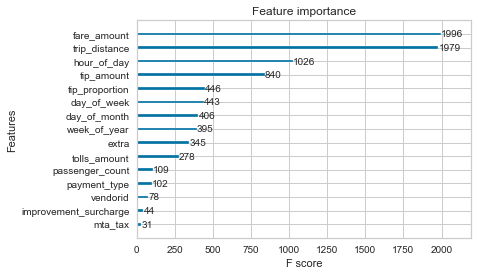

In [15]:
print(best_xgboost.feature_importances_)
xgb.plot_importance(best_xgboost)

## Random Forest

Random forest builds on bagging by random selecting samples, features and getting result from random set of predictors.


In [16]:
model_rf = RandomForestRegressor(n_jobs=-1, max_depth=10, verbose=True).fit(X_train, y_train)

/Users/zachguan/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/zachguan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    5.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.0s finished


In [17]:
# Train
y_pred = model_rf.predict(X_train)
train_loss = get_rmse(y_train, y_pred)
print("Train Loss: {}".format(train_loss))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s


Train Loss: 1.5031000614135892


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.2s finished


In [18]:
# Test
y_pred = model_rf.predict(X_test)
test_loss = get_rmse(y_test, y_pred)
print("Test Loss: {}".format(test_loss))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


Test Loss: 1.6148610137184969


In [19]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
from sklearn.tree import export_graphviz
from graphviz import Source
estimator = model_rf.estimators_[1]

from IPython.display import SVG
graph = Source(export_graphviz(estimator, out_file=None, feature_names=X_train.columns))
SVG(graph.pipe(format='svg'))

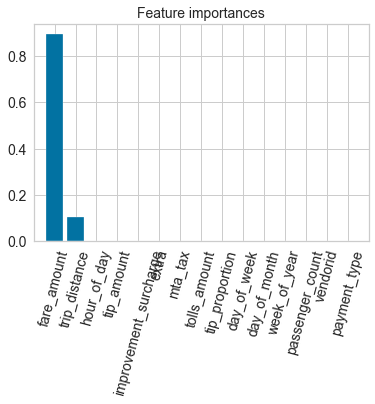

In [20]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]
columns = X_train.columns.tolist()

plt.title("Feature importances", fontsize=14)
plt.bar(range(X_train.shape[1]), importances[indices], color="b",align="center")
plt.xticks(range(X_train.shape[1]), [columns[idx] for idx in indices], rotation=75, fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Gradient Boost

The objective of gradient boost is to minimize the loss of the model by adding decision tree one at a time using gradient descent. 

In [21]:
model_gb = GradientBoostingRegressor(verbose=True).fit(X_train, y_train)

/Users/zachguan/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1          65.4752            2.46m
         2          55.9916            2.17m
         3          48.2102            2.03m
         4          41.8650            1.94m
         5          36.7218            1.86m
         6          32.5224            1.81m
         7          28.9656            1.77m
         8          26.0617            1.75m
         9          23.5721            1.72m
        10          21.4903            1.69m
        20          11.0467            1.46m
        30           7.9380            1.22m
        40           6.6006            1.01m
        50           5.6216           48.85s
        60           4.8043           38.20s
        70           4.2487           28.19s
        80           3.8370           18.71s
        90           3.4981            9.34s
       100           3.2825            0.00s


In [22]:
# Train
y_pred = model_gb.predict(X_train)
train_loss = get_rmse(y_train, y_pred)
print("Train Loss: {}".format(train_loss))

Train Loss: 1.8117712964760124


In [23]:
# Test
y_pred = model_gb.predict(X_test)
test_loss = get_rmse(y_test, y_pred)
print("Test Loss: {}".format(test_loss))

Test Loss: 1.8866243906411992


## Neural Networks

In [24]:
# https://keras.io/getting-started/sequential-model-guide/
model_nn = models.Sequential()
model_nn.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model_nn.add(BatchNormalization())
model_nn.add(Dense(64, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(32, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(8, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(1))

optimizer = optimizers.Adam(lr=1e-4)
model_nn.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [25]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2048      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 2

In [26]:
history = model_nn.fit(
                x=X_train,
                y=y_train,
                validation_data=(X_test, y_test), 
                batch_size=256,
                epochs=8,
                shuffle=True,
                verbose=1
            )

Train on 956866 samples, validate on 239217 samples
Epoch 1/8
956866/956866 [==============================] - 56s 58us/sample - loss: 193.6744 - mae: 13.4608 - val_loss: 137.3716 - val_mae: 11.6031
Epoch 2/8
956866/956866 [==============================] - 54s 57us/sample - loss: 85.1627 - mae: 8.9168 - val_loss: 39.6931 - val_mae: 6.0907
Epoch 3/8
956866/956866 [==============================] - 54s 56us/sample - loss: 15.9633 - mae: 3.3626 - val_loss: 3.5804 - val_mae: 1.1663
Epoch 4/8
956866/956866 [==============================] - 53s 56us/sample - loss: 2.9309 - mae: 1.0562 - val_loss: 2.6791 - val_mae: 0.8957
Epoch 5/8
956866/956866 [==============================] - 53s 56us/sample - loss: 2.7615 - mae: 1.0126 - val_loss: 2.5810 - val_mae: 0.8824
Epoch 6/8
956866/956866 [==============================] - 55s 58us/sample - loss: 2.7254 - mae: 1.0052 - val_loss: 2.5419 - val_mae: 0.8608
Epoch 7/8
956866/956866 [==============================] - 56s 58us/sample - loss: 2.6827 - m

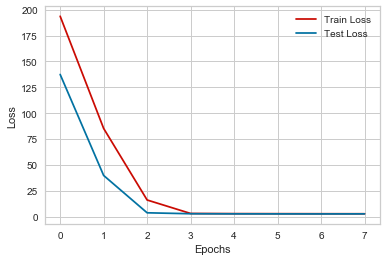

In [30]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epochs = np.arange(len(train_loss))

plt.plot(epochs, train_loss, 'r')
plt.plot(epochs, test_loss, 'b')
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()